In [1]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# STEP 2: Unzip your dataset
import zipfile
import os

# Path to your zip files in Google Drive
zip_path_train = '/content/drive/MyDrive/ML_Assignment/train_dataset.csv.zip'
zip_path_test = '/content/drive/MyDrive/ML_Assignment/test_dataset.csv.zip'

# Destination to extract
extract_to = '/content/data'

# Create directory
os.makedirs(extract_to, exist_ok=True)

# Extract train
with zipfile.ZipFile(zip_path_train, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Extract test
with zipfile.ZipFile(zip_path_test, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [3]:
# STEP 3: Load the CSV files
import pandas as pd

train_df = pd.read_csv('/content/data/train_dataset.csv')
test_df = pd.read_csv('/content/data/test_dataset.csv')


# Preview data
train_df.head()


,url,label,source,url_has_login,url_has_client,url_has_server,url_has_admin,url_has_ip,url_isshorted,url_len,...,pdomain_count_hyphen,pdomain_count_atrate,pdomain_count_non_alphanum,pdomain_count_digit,tld_len,tld,tld_is_sus,pdomain_min_distance,subdomain_len,subdomain_count_dot
0,irs-profilepaymentservice.com/home,1,phishtank,0,0,0,0,0,0,34,...,0,0,0,0,3,com,0,17,0,0
1,cpuggsukabumi.id,0,majestic_million,0,0,0,0,0,0,16,...,0,0,0,0,2,id,1,10,0,0
2,members.tripod.com/~don_rc/ring.htm,0,data_clean_test_mendel,0,0,0,0,0,0,35,...,0,0,0,0,3,com,0,2,7,0
3,optuswebmailadminprovider.weebly.com/,1,phishtank,0,0,0,1,0,0,37,...,0,0,0,0,3,com,0,3,25,0
4,topoz.com.pl,0,dmoz_harvard,0,0,0,0,0,0,12,...,0,0,0,0,6,com.pl,0,3,0,0


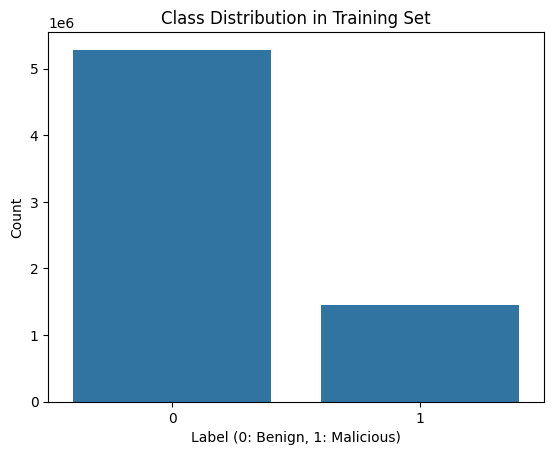

label
0    5283175
1    1445673
Name: count, dtype: int64


In [4]:
# STEP 4: Check class balance in the training dataset
import seaborn as sns
import matplotlib.pyplot as plt

# Count of each class
sns.countplot(data=train_df, x='label')
plt.title('Class Distribution in Training Set')
plt.xlabel('Label (0: Benign, 1: Malicious)')
plt.ylabel('Count')
plt.show()

# Optional: Print exact numbers
print(train_df['label'].value_counts())


In [5]:
# STEP 5: Handle missing values (optional, depending on dataset)
train_df = train_df.dropna()
test_df = test_df.dropna()


In [6]:
# STEP 6: Drop non-numeric / ID columns like 'url' if present
# (XGBoost requires numerical input)
X_train = train_df.drop(columns=['label', 'url'], errors='ignore')
y_train = train_df['label']

X_test = test_df.drop(columns=['label', 'url'], errors='ignore')
y_test = test_df['label']


In [7]:
# # STEP 6: One-hot encode non-numeric (object) columns
# X_train = pd.get_dummies(X_train)
# X_test = pd.get_dummies(X_test)

# # Align test columns with train
# X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [8]:
# STEP 6: Split training data into train and validation sets
from sklearn.model_selection import train_test_split

# First prepare features and target as you already did
X_train_full = train_df.drop(columns=['label', 'url'], errors='ignore')
y_train_full = train_df['label']

# Now split the training data to create a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=y_train_full  # Maintain class distribution
)

# Continue with one-hot encoding
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)
X_test = pd.get_dummies(X_test)

# Align validation and test columns with train
all_columns = X_train.columns
X_val = X_val.reindex(columns=all_columns, fill_value=0)
X_test = X_test.reindex(columns=all_columns, fill_value=0)

In [9]:
# STEP 7: Calculate scale_pos_weight
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")


scale_pos_weight: 3.65


In [10]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 4.9 MB/s eta 0:00:00


In [11]:
# STEP 8: Train XGBoost with GPU support
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create directory for model saving
save_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(save_dir, exist_ok=True)

# Check if GPU is available
!nvidia-smi

model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=3,
    min_child_weight=2,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=20,
    reg_lambda=50,
    learning_rate=0.00001,
    n_estimators=80,
    # tree_method='gpu_hist',  # This enables GPU acceleration
    # predictor='gpu_predictor',
    eval_metric='logloss',
    random_state=42
)

# Use validation set for early stopping
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)]
)

# Save the trained model
model.save_model(os.path.join(save_dir, 'xgboost_model.model'))  # Default binary format
model.save_model(os.path.join(save_dir, 'xgboost_model.json'))  # Human-readable JSON


/bin/bash: line 1: nvidia-smi: command not found
[0]	validation_0-logloss:0.69314	validation_1-logloss:0.69314
[1]	validation_0-logloss:0.69314	validation_1-logloss:0.69314
[2]	validation_0-logloss:0.69313	validation_1-logloss:0.69313
[3]	validation_0-logloss:0.69313	validation_1-logloss:0.69313
[4]	validation_0-logloss:0.69312	validation_1-logloss:0.69312
[5]	validation_0-logloss:0.69311	validation_1-logloss:0.69311
[6]	validation_0-logloss:0.69310	validation_1-logloss:0.69310
[7]	validation_0-logloss:0.69309	validation_1-logloss:0.69309
[8]	validation_0-logloss:0.69309	validation_1-logloss:0.69309
[9]	validation_0-logloss:0.69308	validation_1-logloss:0.69308
[10]	validation_0-logloss:0.69307	validation_1-logloss:0.69307
[11]	validation_0-logloss:0.69306	validation_1-logloss:0.69306
[12]	validation_0-logloss:0.69306	validation_1-logloss:0.69306
[13]	validation_0-logloss:0.69305	validation_1-logloss:0.69305
[14]	validation_0-logloss:0.69304	validation_1-logloss:0.69304
[15]	validation_

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [09:32:50] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


In [12]:
pip install matplotlib seaborn pandas

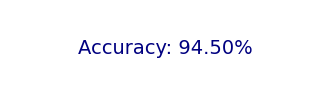

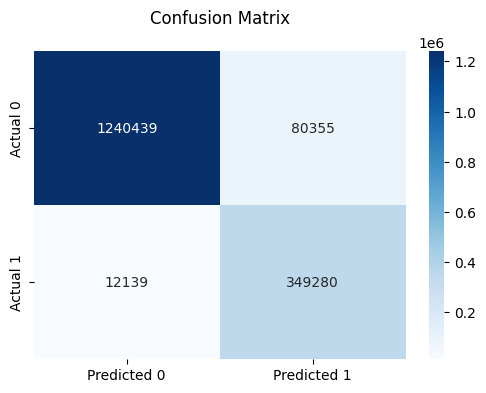


Classification Report:
              precision    recall  f1-score   support

           0     0.9903    0.9392    0.9641   1320794
           1     0.8130    0.9664    0.8831    361419

    accuracy                         0.9450   1682213
   macro avg     0.9016    0.9528    0.9236   1682213
weighted avg     0.9522    0.9450    0.9467   1682213



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def print_evaluation(y_true, y_pred):
    # 1. Accuracy Display
    plt.figure(figsize=(4, 1))
    plt.text(0.5, 0.5, f"Accuracy: {accuracy_score(y_true, y_pred):.2%}",
             ha='center', va='center', fontsize=14, color='navy')
    plt.axis('off')
    plt.show()

    # 2. Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix', pad=20)
    plt.show()

    # 3. Classification Report (plain text format)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

# Usage
y_pred = model.predict(X_test)
print_evaluation(y_test, y_pred)